Contents
  - <a href='#Feasibility-of-ammonia-aqua-chiller'>Feasibility of ammonia-aqua chiller¶</a>
    - <a href='#Definitions'>Definitions¶</a>
      - <a href='#Generator/desorber'>Generator/desorber¶</a>
      - <a href='#Rectifier:'>Rectifier:¶</a>
      - <a href='#Absorber:'>Absorber:¶</a>
      - <a href='#Other-assumptions'>Other assumptions¶</a>
    - <a href='#Constraints'>Constraints¶</a>
      - <a href='#Initial-inputs'>Initial inputs¶</a>
      - <a href='#Absorber'>Absorber¶</a>
      - <a href='#Generator'>Generator¶</a>
      - <a href='#Rectifier'>Rectifier¶</a>
    - <a href='#Implementation'>Implementation¶</a>
      - <a href='#Desired-behavior'>Desired behavior¶</a>
      - <a href='#Code'>Code¶</a>
      - <a href='#Absorber-maximum-allowed-outlet-temperature'>Absorber maximum allowed outlet temperature¶</a>
      - <a href='#Object-oriented-constraint-evaluation'>Object-oriented constraint evaluation¶</a>
      - <a href='#Widget-demonstration'>Widget demonstration¶</a>
      - <a href='#Visualize-feasible-/-infeasible-regions'>Visualize feasible / infeasible regions¶</a>
      - <a href='#Problem-cases'>Problem cases¶</a>
    - <a href='#Appendix'>Appendix¶</a>
      - <a href='#Visualize-relations-between-a-few-variables-of-state'>Visualize relations between a few variables of state¶</a>
      - <a href='#Evaporator-vapor-quality-effect-on-operating-pressure-and-maximum-solution-rich-mass-fraction'>Evaporator vapor quality effect on operating pressure and maximum solution rich mass fraction¶</a>

# Feasibility of ammonia-aqua chiller

In [1]:
%%html
<img src="../img/Diagram_for_ammonia.svg">
<img src="./img/Diagram_for_ammonia.svg">

## Definitions

- $T_{evap}$ : temperature at evaporator outlet (point 13)
- $T_{cond}$ : temperature at condenser outlet (point 10)
- $T_{abs}$ : Temperature at absorber liquid outlet (point 1)
- $T_{gen}$ : Temperature at generator liquid outlet (point 4)
- $T_{rect}$ : Temperature at rectifier vapor outlet (point 9)
- $x_{refrig}$ : The ammonia mass fraction in the refrigerant stream (points 9, 10, 11, 12, 13, 14)
- $x_{rich}$ : The ammonia mass fraction in the rich stream (points 1, 2, 3, 3')
- $x_{weak}$ : The ammonia mass fraction in the weak stream (points 4, 5, 6)
- $Qu_{evap}$ : the vapor quality at the evaporator outlet (point 13) (typically less than 1 because there is some water in the refrigerant)

### Generator/desorber

- Assumptions are designed to give the "best case" of performance.
- Assumption: vapor produced in the desorber is everywhere locally in equilibrium with the liquid.
- Assumption: vapor flows counter to liquid, ie. from near point 4 toward point 3', so all vapor going to rectifier comes from near point 3'. This assumption affects the computation of the heat vs temperature demand curve in the desorber HX.
- Point 3 : Rich stream entering desorber, typically subcooled.
- Point 3' : The point in the rich stream where external heating brings it to saturated state (Qu=0).
- Unnamed point : The vapor stream
- Point 8 : The vapor stream leaving the desorber and entering the rectifier.
- Point 7 : The reflux (liquid) returned from the rectifier to the desorber.

### Rectifier:

- Assumptions are designed to give the best case of performance, equivalent to design with infinite number of plates and size.
- Assumption: liquid formed is everywhere locally in equilibrium with vapor, and flowing counter to it. This assumption affects the computation of the heat vs temperature demand curve.
- Vapor stream starts at point 8 and exits at point 9.
- Liquid stream starts at (unnamed point in equilibrium with point 9) and exits at point 7.

### Absorber:

- Assumption : vapor absorbed is everywhere locally in equilibrium with liquid (or absorbs into subcooled liquid with no resistance) and flowing counter to it.
- Point 1 : Liquid outlet at equilibrium with refrigerant vapor inlet (point 14).
- Assumption : Computation of the heat rejection demand vs temperature curve in the absorber stream (for HX calculations) depends on the weak stream inlet state (point 6) as follows:
  - If it is subcooled, then there is an imagined segment of the process near the weak inlet where the liquid stream absorbs refrigerant without any demand for heat rejection, until the liquid stream reaches saturation and equilibrium.
  - Saturated liquid : The vapor-liquid interface extends through the entire absorber. Absorbing an incremental amount of vapor requires an amount of heat rejection depending on the local equilibrium state and mass flow rates of liquid and vapor.
  - Partially vapor : there is an imagined segment of the absorber near the weak stream inlet where the weak stream just rejects heat via the HX and does not absorb any vapor. Throughout that process, the liquid and vapor are in equilibrium and are represented by one state with the mass fraction of the weak stream. Upon reaching a saturated liquid state, the weak stream enters the main segment of the absorber and begins to absorb from the refrigerant stream.
  - All vapor : there is clearly a problem with the design. But nevertheless, I cool the weak stream all the way to saturated liquid state, just as for partial vapor at inlet.

### Other assumptions

- For purpose of this feasibility question, neglect friction losses and resulting pressure changes.

## Constraints

There are some necessary conditions for the chiller to produce refrigerant flow. I'll try to write these as inequalities, so that we can develop constraint functions that can be used in a solver or optimizer. Drawing a cycle may be feasible for cases with equality, but to actually produce cooling and compute positive mass flow, the inequalities must hold strictly.

### Initial inputs
We assume that $Qu_{evap}$, $x_{refrig}$, $T_{evap}$, and $T_{cond}$ are given. Clearly, we must require that

* $T_{evap} \le T_{cond}$
* $T_{cond}$ less that critical temperature at x_refrig
* $T_{evap}$ greater than freezing temperature at x_refrig

Then we'll compute $P_{evap}$ and $P_{cond}$ from the other inputs.

### Absorber

This is the heart of the cooling cycle, as the absorber is the component that draws a low pressure on the evaporator. At first look, we can constrain the total pressure: $P_{vapor,absorber} \le P_{evap}$. That is,

* $P(T=T_{abs}, x=x_{rich}, Qu=0) \le P_{evap}$

Since the state function is monotonic and increasing wrt. T and x inputs (decreasing wrt. Qu), we could try re-writing alternate forms:

* $ x_{rich,max} := x(T=T_{abs}, P=P_{evap}, Qu=0) \ge x_{rich} $
* $ T(P=P_{evap}, x=x_{rich}, Qu=0) \ge T_{abs} $
* $ Qu(T=T_{abs}, P=P_{evap}, x=x_{rich}) \le 0 $

Since we have not previously determined $x_{rich}$, we can use the constraint limiting it to define $x_{rich,max}$.

Note that the refrigerant vapor coming into the absorber will not be in equilibrium with the rich liquid. This may be considered a loss mechanism intrinsic to the absorption cycle. A restriction more specific than the one above is that partial pressures of both species be less than the partial pressures in the vapor state in equilibrium with the rich saturated liquid (the same total pressure as the vapor state). Using $\bar{x}$ for molar fraction, we have

* Ammonia: $ \bar{x}_{rich} P(T=T_{abs}, x=x_{rich}, Qu=0) \le \bar{x}_{refrig} P_{evap}$
* Water: $ (1-\bar{x}_{rich}) P(T=T_{abs}, x=x_{rich}, Qu=0) \le (1- \bar{x}_{refrig}) P_{evap}$

Typically, $\bar{x}_{rich}$ is on the order of 0.5, whereas $(1-\bar{x}_{refrig})$ is on the order of 0.001 or less. So the constraint on the water vapor pressure is the stricter one; but it turns out that temperatures required to absorb such low pressure water vapor are much too low, so likely all water in the refrigerant stream must be pumped out of the evaporator. Taking $x_{rich}$ as given, we can put the ammonia absorption constraint in terms of $T_{abs}$, as follows. First, define

$$ P_{abs}(x_{rich}) = \frac{\bar{x}_{refrig}}{\bar{x}_{rich}} P_{evap} $$

Now we have

* $ T(P=P_{abs}(x_{rich}), x=x_{rich}, Qu=0) \ge T_{abs} $

or in other words

$$ T_{abs,max}(x_{rich}) := T(P=P_{abs}(x_{rich}), x=x_{rich}, Qu=0) $$

The saturation function on the right is decreasing wrt. $x_{rich}$ and increasing wrt. $P_{abs}$, which in turn is decreasing in $x_{rich}$; so all together $T_{abs,max}$ is decreasing. (Below, the function is explored numerically.) Thus

\begin{align}
T_{abs} &\le T_{abs,max}(x_{rich,max}) \\
& \le T_{abs,max}(x_{rich})
\end{align}

The first inequality is sufficient to gaurantee feasible operation of the absorber, although not necessary. In a real system, mass flow resistance will prevent $x_{rich}$ from reaching its maximum, in which case the upper limit on $T_{abs}$ (favorably) increases; this would have an unfavorable effect on the temperature required in the generator, which will be seen in the next section.


### Generator

For the generator to produce vapor, we merely need it to heat the inlet stream beyond saturation. (We place no requirement on the mass fraction of the vapor coming off, since the rectifier will control what is ultimately delivered as refrigerant.) So to start, we can write the constraint:

* $ Qu(T=T_{gen}, P=P_{cond}, x=x_{rich}) \ge 0 $, with alternate forms:
  * $ x(...) \le x_{rich}$
  * $ P(...) \ge P_{cond}$
  * $ T(...) \le T_{gen}$

Although we have not previously fixed the rich stream ammonia mass fraction, $x_{rich}$, we do have a constraint on that resulting from the constraints on the absorber:

$$ x_{rich} \le x_{rich,max} $$

Via the transitive property, this relation together with the appropriate form of the constraint gives:

* $ x(T=T_{gen}, P=P_{cond}, Qu=0) \le x(T=T_{abs}, P=P_{evap}, Qu=0) $

The right hand side may be called $x_{rich,max}$, so all the alternate versions of this constraint are:

* $ x(T=T_{gen}, P=P_{cond}, Qu=0) \le x_{rich,max} $
* $ P(T=T_{gen}, x=x_{rich,max}, Qu=0) \ge P_{cond} $
* $ T(x=x_{rich,max}, P=P_{cond}, Qu=0) \le T_{gen} $
* $ Qu(T=T_{gen}, P=P_{cond}, x=x_{rich,max}) \ge 0 $

We should note that this new inequality is necessary to guarantee vapor formation, but since we dropped the intermediate inequality, it is worthwhile to ask whether it is sufficient. Well, as more refrigerant flows, $x_{rich}$ must drop below $x_{rich,max}$ (to be able to pick up a larger ammonia mass) and this pushes up the lower limit on $T_{gen}$. However, in the limiting case as refrigerant flow drops to zero (for fixed rich solution flow), $x_{rich}$ and $x_{weak}$ converge. Considering the supply heat demand, a goal of keeping $T_{gen}$ to a minimum favors that the ammonia solution be rich as possible. Considering the heat reject load, a goal of keeping $T_{abs}$ to a maximum favors that the ammonia solution be as weak as possible. So the absorber and desorber are in disagreement; but for a barely feasible case, we can use $x_{rich,max}$.

### Rectifier

The rectifier must cool and purify the ammonia content of the vapor stream to $x_{refrig}$. However, once having determined the condenser pressure, the final extent of the process, assuming equilibrium, could be specified by either $x_{refrig}$ or $T_{rect}$. But in the previous constraints we already assumed that $x_{refrig}$ was used to determine pressure levels, so here let's just constrain $T_{rect}$ this way:

- $x_{refrig} \le x(T=T_{rect}, P=P_{cond}, Qu = 1)$
- $T_{rect} \le T(P=P_{cond}, x=x_{refrig}, Qu = 1)$

In this case, the system can produce positive cooling even when strict equality holds, so we can justify throwing away the $T_{rect}$ as an unnecessary input.

## Implementation

### Desired behavior

The main reason we need to implement these constraints as functions is to help optimizers avoid infeasible domains. However, "avoid" is not yet clearly defined, and depends on the behavior of the optimizer.

1. If we have an optimizer that strictly obeys constraints (ie. does not evaulate the objective outside the feasible domain), then we need only define the behavior of constraint functions in the feasible domain.
2. If we have an optimizer that does not strictly obey constraints, we need to extend the definition of the constraint and objective functions to guarantee that the optimizer will not receive an exception and quit.

The possibility of using a good, unconstrained optimizer is motivation for exploring case 2, but even some optimizers that accept constraints will need to evaluate those constraints at points slightly outside the feasible domain. Some of the constraint functions require property lookups that can fail by exception; in that case, a typical strategy is to return an arbitrary large cost for the constraint. Using an infinite cost results in bad behavior for gradient-based methods, but even with finite values the constraints are still discontinuous. So, can we extend the definition of the constraint and objective functions, and how? This "patching" should be continuous and create costs increasing outside the feasible domain. For a model as simple as this single-effect chiller, we know the boundaries of feasibility (per the above derivations). So considerably, we could map any infeasible input point to a feasible point on the boundary. The first trick would be to make the mapping continuous. Secondly, we still need at least one of the constraints to show an increasing cost. Indeed the following method allows us to extend the definitions of the constraint functions.

* We define the constraints in terms of upper and lower bounds on input variables as functions of other variables.
* We evaluate the constraints in a sequence. When a constraint does not hold, we *override* the value of the relavent input for successive evaluations.
* For that, we preserve the original input variable for comparison to the derived boundary for that variable.

It appears that this works for the present model because the model is solved fairly explicitly (without iteration and circular dependence) and because there is a sequence of constraints for which evaluation of the first boundary is guaranteed, and successive boundaries depend only on variables that are already constrained. In more general cases, here are some suggestions:

1. Attempt to apply the override method, using sequential evaluation of constraints and adjustment of input variables.
2. If that method does not work, insert a meta-model between the model and the optimizer to catch exceptions from infeasible inputs. The meta-model must do two things: for infeasible inputs, catch the exception and return a high cost. Meanwhile, it must collect all the points visited by the optimizer and classify them as feasible/infeasible, and use the data to develop via regression a constraint function that fits the infeasible domain and has properties that encourage convergence back to the feasible domain.
3. Alternatively, if there is way to define a continuous mapping into the feasible domain (eg. by a backtracking linesearch to the boundary), the meta-model could apply this mapping.

The question remains whether there are generic or universal algorithms for other types of models.

### Code

Note that the above derivations make use of the molar fraction, $\bar{x}$, but some of the implementation functions use mass basis.

In [1]:
import CoolProp.CoolProp as CP
from ammonia_props import massFractionToMolar, AmmoniaProps
import ammonia1
amm=ammonia1.amm
import numpy
from numpy import array, nan, inf
import matplotlib.pyplot as plt


In [2]:
import ammonia_props
ammonia_props.availableCodeStringsForward

{123: ['T', 'P', 'x'],
 128: ['T', 'P', 'Qu'],
 137: ['T', 'x', 'v'],
 138: ['T', 'x', 'Qu'],
 148: ['T', 'h', 'Qu'],
 158: ['T', 's', 'Qu'],
 168: ['T', 'u', 'Qu'],
 178: ['T', 'v', 'Qu'],
 234: ['P', 'x', 'h'],
 235: ['P', 'x', 's'],
 238: ['P', 'x', 'Qu'],
 248: ['P', 'h', 'Qu'],
 258: ['P', 's', 'Qu'],
 268: ['P', 'u', 'Qu'],
 278: ['P', 'v', 'Qu']}

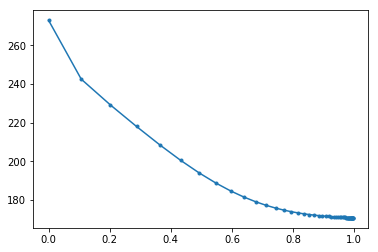

In [4]:
p_min = 0.006 # (bar) -- refer to benchmark_nh3h2o.ipynb
astate = amm.props2(P=p_min,x=0.998,Qu=0)
astate
import numpy
x_refrig = 1-numpy.logspace(0,-8,base=2)
T_min_cond = amm.props2v(P=p_min,x=x_refrig,Qu=0)[0]
import matplotlib.pyplot as plt
plt.plot(x_refrig, T_min_cond,'.-')
plt.show()

### Absorber maximum allowed outlet temperature

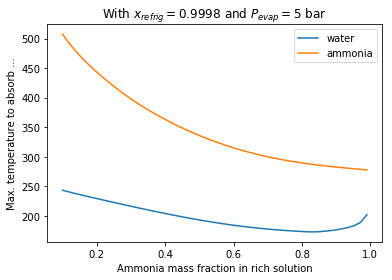

In [5]:
# Absorber: plotting T_abs,max vs x_rich to find maximum
def P_abs_water(x_rich,x_refrig,P_evap):
    x_molar_rich = massFractionToMolar(x_rich)
    x_molar_refrig = massFractionToMolar(x_refrig)
    alpha = (1 - x_molar_refrig) / (1 - x_molar_rich)
    result = alpha * P_evap
    return result

def P_abs_ammonia(x_rich,x_refrig,P_evap):
    x_molar_rich = massFractionToMolar(x_rich)
    x_molar_refrig = massFractionToMolar(x_refrig)
    #alpha = (1 - x_molar_refrig) / (1 - x_molar_rich)
    alpha = (x_molar_refrig) / (x_molar_rich)
    result = alpha * P_evap
    return result

def T_abs_max_func(x_rich,P_abs):
    return amm.props2(x=x_rich,P=P_abs,Qu=0,out='T')

x_refrig = 0.9998
P_evap = 5 # bar
x_rich = numpy.linspace(0.1,0.99)
T_abs_ammonia = numpy.empty_like(x_rich)
T_abs_ammonia.fill(numpy.nan)
T_abs_water = T_abs_ammonia.copy()

p_min = 0.006
for i, x_rich_i in enumerate(x_rich):
    try:
        p1 = P_abs_ammonia(x_rich_i, x_refrig, P_evap)
        if p1 < p_min:
            p1 = p_min
        T_abs_ammonia[i] = T_abs_max_func(x_rich_i, p1)
    except:
        pass
    try:
        p2 = P_abs_water(x_rich_i, x_refrig, P_evap)
        if p2 < p_min:
            p2 = p_min
        T_abs_water[i] = T_abs_max_func(x_rich_i, p2)
    except:
        pass
plt.figure()
plt.title("With $x_{{refrig}}={}$ and $P_{{evap}}={}$ bar".format(x_refrig, P_evap))
plt.xlabel("Ammonia mass fraction in rich solution")
plt.ylabel("Max. temperature to absorb ...")
plt.plot(x_rich,T_abs_water,label="water")
plt.plot(x_rich,T_abs_ammonia,label="ammonia")
plt.legend()

plt.show()

### Object-oriented constraint evaluation

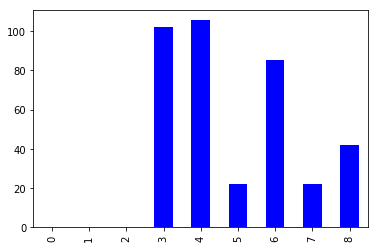

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310,4.75071,0.508281,-74.4766,0.391835,-75.0599,0.00122787,0
rich_pump_outlet,310.093,10.6161,0.508281,-73.5762,0.392416,-74.8794,0.0012276,-0.001
rich_shx_outlet,339.161,10.6161,0.508281,76.3836,0.851874,72.9667,0.00321857,0.0136051
rich_gen_sat_liquid,338.09,10.6161,0.508281,53.8805,0.785932,52.5292,0.00127282,0
weak_gen_outlet,380,10.6161,0.296492,278.322,1.35832,277.029,0.00121791,0
weak_shx_outlet,331.449,10.6161,0.296492,63.7467,0.754536,62.5309,0.00114525,-0.001
weak_exp_outlet,331.554,4.75071,0.296492,63.7467,0.756563,63.2024,0.00114571,-0.001
gen_vapor_outlet,338.09,10.6161,0.991505,1404.76,4.67404,1252.02,0.143873,1
gen_reflux_inlet,338.09,10.6161,0.508144,53.4903,0.784686,52.1388,0.00127304,0
refrig_rect_outlet,310,10.6161,0.9998,1319.41,4.40903,1183.88,0.127667,1.001


In [35]:
import pandas

class AquaChillerSpec1:
    
    n_cons = 9
    Qu_evap = 0.998
    x_refrig_min = 0.9
    x_refrig_max = 1.0
    x_rich_min = 1e-1
    x_rich_max_max = 1.0
    
    def __init__(self,T_abs=300,T_cond=300,T_evap=278,T_gen=380,T_rect=310,
                 x_refrig=0.9998,throws=False):
        self.T_abs = T_abs
        self.T_cond = T_cond
        self.T_evap = T_evap
        self.T_gen = T_gen
        self.T_rect = T_rect
        self.x_refrig = x_refrig
        
        self.x_rich = nan
        self.T_abs_mapped = T_abs
        self.T_cond_mapped = T_cond
        self.T_evap_mapped = T_evap
        self.T_gen_mapped = T_gen
        self.T_rect_mapped = T_rect
        self.x_refrig_mapped = x_refrig
        
        self.T_cond_max = nan
        self.T_evap_min = nan
        self.T_abs_max1 = nan
        self.T_abs_max2 = nan
        self.x_rich_max = nan
        self.T_gen_min = nan
        self.P_cond = nan
        self.P_evap = nan
        self.C = pandas.Series(data=[-999.0]*self.n_cons,dtype='float')
        self.messages=[]
        self.html_opts = dict(inputs=True,limits=True,mapped=True,constraints=True,warnings=True)
        
    def cons(self):
        self.messages=[]
        self.C[:] = -999.0
        
        try:
            # A trivial constraint that is always satisfied
            self.C[0] = 0
            
            # Basics
            self.x_refrig_mapped = self.x_refrig
            self.C[1] = self.x_refrig - self.x_refrig_min
            if self.C[1] < 0:
                self.messages.append("x_refrig ({:g}) should be greater than {:g} but is not."
                                     .format(self.x_refrig,self.x_refrig_min))
                self.x_refrig_mapped = self.x_refrig_min
            
            self.C[2] = self.x_refrig_max - self.x_refrig
            if self.C[2] < 0:
                self.messages.append("x_refrig ({:g}) should be less than {:g} but is not."
                                    .format(self.x_refrig,self.x_refrig_max))
                self.x_refrig_mapped = self.x_refrig_max
            
            self.T_evap_mapped = self.T_evap
            self.T_evap_min = amm.props2(P=0.01,x=self.x_refrig_mapped,Qu=self.Qu_evap,out="T")
            self.C[3] = (self.T_evap - self.T_evap_min)
            if self.C[3] < 0:
                self.messages.append("T_evap ({:g}) should be greater than {:g} but is not."
                                     .format(self.T_evap, self.T_evap_min))
                self.T_evap_mapped = self.T_evap_min
            
            self.T_cond_mapped = self.T_cond
            # convert mass fraction to molar only for Refprop
            x_molar_refrig = massFractionToMolar(self.x_refrig_mapped)
            self.T_cond_max = CP.PropsSI('Tcrit',
                'REFPROP::ammonia[{}]&water[{}]'.format(
                x_molar_refrig, 1.0 - x_molar_refrig))
            self.C[4] = (self.T_cond_max - self.T_cond)
            if self.C[4] < 0:
                self.messages.append("T_cond ({:g}) should be less than {:g} but is not."
                                     .format(self.T_cond, self.T_cond_max))
                self.T_cond_mapped = self.T_cond_max
                
            self.C[5] = (self.T_cond - self.T_evap)
            if self.C[5] < 0:
                self.messages.append("T_cond ({:g}) should be greater than T_evap ({:g}) but is not."
                                    .format(self.T_cond, self.T_evap))
                if self.T_evap_mapped < self.T_cond_max:
                    self.T_cond_mapped = self.T_evap_mapped
                elif self.T_cond_mapped > self.T_evap_min:
                    self.T_evap_mapped = self.T_cond_mapped
                else:
                    self.T_evap_mapped = self.T_cond_max
                    self.T_cond_mapped = self.T_evap_mapped

            self.P_cond = amm.props2(T=self.T_cond_mapped, x=self.x_refrig_mapped, Qu=0, out="P")
            self.P_evap = amm.props2(T=self.T_evap_mapped, x=self.x_refrig_mapped, Qu=self.Qu_evap, out="P")

            # TODO: explain in write-up above
            # I had started off with constraint 'x_rich_max > 0',
            # but it appears that an equivalent statement is 'T_abs < T(x=0, ...)'.
            # This seems preferrable since following calculations depend on T_abs,
            # so we can adjust T_abs to the allowed limit,
            # whereas violation of limit on x_rich_max is not as easy to correct/override(?)
            self.T_abs_mapped = self.T_abs
            self.T_abs_max1 = amm.props2(x=self.x_rich_min, P=self.P_evap, Qu=0, out="T")
            self.C[6] = (self.T_abs_max1 - self.T_abs)
            if self.C[6] < 0:
                self.messages.append("T_abs ({:}) should be less than {:g} but is not."
                                     .format(self.T_abs, self.T_abs_max1))
                self.T_abs_mapped = self.T_abs_max1
            
            # Also, enforce 'x_rich_max < 1'
            # First determine maximum equilibrium pressure at this temperature,
            # that is, when x_rich is 1, so that we don't call State function with invalid inputs.
            # If evaporator pressure is higher, no problem; even pure ammonia can absorb
            # by simple condensation.
            P_max = amm.props2(T=self.T_abs_mapped, x=self.x_rich_max_max, Qu=0, out="P")
            if P_max < self.P_evap:
                self.x_rich_max = self.x_rich_max_max
                self.x_rich = self.x_rich_max
            else:
                # This must be guarded by the above if-statement.
                # For P_evap slightly in excess of max, the function
                # returns x slightly greater than 1. For larger values, it fails altogether.
                self.x_rich_max = amm.props2(T=self.T_abs_mapped, P=self.P_evap, Qu=0, out="x")
                self.x_rich = self.x_rich_max
                if self.x_rich > self.x_rich_max_max:
                    self.x_rich = self.x_rich_max_max
            
            self.T_abs_max2 = T_abs_max_func(self.x_rich,
                                            P_abs_ammonia(self.x_rich, self.x_refrig_mapped, self.P_evap))
            self.C[7] = (self.T_abs_max2 - self.T_abs)
            if self.C[7] < 0:
                self.messages.append("T_abs should be less than {:g} but is not.".format(self.T_abs_max2))
                # Should already have been fixed by previous constraint ... get rid of this one
                # self.T_abs_mapped = self.T_abs_max2
            
            self.T_gen_min = amm.props2(P=self.P_cond, x=self.x_rich, Qu=0).T
            self.C[8] = (self.T_gen - self.T_gen_min)
            if self.C[8] < 0:
                self.messages.append("T_gen should be greater than {:g} but is not.".format(self.T_gen_min))
                self.T_gen = self.T_gen_min
        
        except KeyError as e:
            self.messages.append(e.__repr__())
            raise
        except ValueError as e:
            self.messages.append(e.__repr__())
            raise
        except:
            raise

        return self.C
    
    def _repr_html_(self):
        return self.html_helper(**self.html_opts)
    
    def html_helper(self,inputs=True,limits=True,mapped=True,constraints=True,warnings=True):
        result = ""
        if inputs:
            result += """<h5>Inputs</h5>
                <ul><li>T_abs = {:g}</li><li>T_cond = {:g}</li><li>T_evap = {:g}</li>
                <li>T_gen = {:g}</li><li>T_rect = {:g}</li><li>x_refrig = {:g}</li></ul>""".format(
                self.T_abs, self.T_cond, self.T_evap, self.T_gen, self.T_rect, self.x_refrig)
        if limits:
            result += """<h5>Computed limits</h5>
                <ul>
                <li>x_refrig_min = {:g}</li><li>x_refrig_max = {:g}</li>
                <li>T_cond_max = {:g}</li><li>T_evap_min = {:g}</li>
                <li>P_cond = {:g}</li><li>P_evap = {:g}</li>
                <li>T_abs_max1 = {:g}</li><li>x_rich_max = {:g}</li>
                <li>x_rich = {:g}</li>
                <li>T_abs_max2 = {:g}</li><li>T_gen_min = {:g}</li></ul>""".format(
                self.x_refrig_min, self.x_refrig_max,
                self.T_cond_max, self.T_evap_min,
                self.P_cond, self.P_evap,
                self.T_abs_max1, self.x_rich_max,
                self.x_rich,
                self.T_abs_max2, self.T_gen_min)
        if mapped:
            result += """<h5>Mapped inputs</h5>
                <ul><li>T_abs = {:g}</li><li>T_cond = {:g}</li><li>T_evap = {:g}</li>
                <li>T_gen = {:g}</li><li>T_rect = {:g}</li><li>x_refrig = {:g}</li></ul>""".format(
                self.T_abs_mapped, self.T_cond_mapped, self.T_evap_mapped, self.T_gen_mapped,
                self.T_rect_mapped, self.x_refrig_mapped)
        if constraints:
            result += """<h5>Constraint functions</h5>
                <pre>{}</pre>""".format(self.C)
        if warnings:
            result += """<h5>Warnings</h5>
                <ul>{}</ul>""".format("".join(
                map(lambda msg: "<li>{}</li>".format(msg),
                    ["None."] if len(self.messages) == 0 else self.messages)))
        return result
    

a1 = AquaChillerSpec1(T_abs=310)
cons = a1.cons()
display(a1)
colors = cons.map(lambda c: 'b' if c > 0 else 'r')
b = cons.plot.bar(color="".join(colors.tolist()))
plt.show()
ch = ammonia1.AmmoniaChiller()
ch.update(x_refrig=a1.x_refrig, T_evap=a1.T_evap, T_cond=a1.T_cond,
          T_abs_outlet=a1.T_abs, T_gen_outlet=a1.T_gen, T_rect=a1.T_rect)
display(ch)

In [43]:
'hello' == 'hello'

True

### Widget demonstration

In [56]:
%matplotlib inline
import ipywidgets as widgets
import widgetsnbextension
from ipywidgets import interactive

import system_aqua1
import ammonia1

common_opts = dict(
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
w_m_rich = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=2.0,
    step=0.05,
    description='m_rich',
    readout_format='.2f',
    **common_opts
)
w_T_evap = widgets.FloatSlider(
    value=278.0,
    min=200.0,
    max=300.0,
    step=0.1,
    description='T_evap',
    readout_format='.1f',
    **common_opts
)
w_T_cond = widgets.FloatSlider(
    value= 312.2,
    min=200,
    max=400,
    step=0.1,
    description='T_cond',
    readout_format='.1f',
    **common_opts
)
w_T_rect = widgets.FloatSlider(
    value=313.7,
    min=200.0,
    max=400.0,
    step=0.1,
    description='T_rect',
    readout_format='.1f',
    **common_opts
)
w_T_abs_outlet = widgets.FloatSlider(
    value=310.2,
    min=200.0,
    max=400.0,
    step=0.1,
    description='T_abs_outlet',
    readout_format='.1f',
    **common_opts
)
w_T_gen_outlet = widgets.FloatSlider(
    value=374.1,
    min=200.0,
    max=500.0,
    step=0.1,
    description='T_gen_outlet',
    readout_format='.1f',
    **common_opts
)
w_x_refrig = widgets.FloatSlider(
    value = 0.998,
    min = 0.8,
    max = 1.1,
    step = 0.001,
    description='x_refrig',
    readout_format='.4f',
    **common_opts
)
def f(m_rich, T_evap, T_cond, T_rect, T_abs_outlet, T_gen_outlet, x_refrig):
    
    a1 = AquaChillerSpec1(T_abs_outlet, T_cond, T_evap, T_gen_outlet, T_rect, x_refrig)
    cons = a1.cons()
    #a1.shows=['Warnings']
    display(a1)
    colors = "".join(cons.map(lambda c: 'b' if c > 0 else 'r').tolist())
    b = cons.plot.bar(color=colors)
    plt.show()
    
    ch = ammonia1.AmmoniaChiller()
    try:
        ch.update(x_refrig=a1.x_refrig, T_evap=a1.T_evap, T_cond=a1.T_cond,
            T_abs_outlet=a1.T_abs, T_gen_outlet=a1.T_gen, T_rect=a1.T_rect)
        display(ch)
    except:
        print("Couldn't create chiller")
    
#widgets.VBox(w_m_rich,w_T_evap,w_T_cond,w_T_rect,w_T_abs_outlet,w_T_gen_outlet)
interactive(f,
            m_rich=w_m_rich,
            T_evap=w_T_evap,
            T_cond=w_T_cond,
            T_rect=w_T_rect,
            T_abs_outlet=w_T_abs_outlet,
            T_gen_outlet=w_T_gen_outlet,
            x_refrig=w_x_refrig
           )

A Jupyter Widget

In [97]:
a1.C[1]

0

### Visualize feasible / infeasible regions

In [7]:
list(range(AquaChillerSpec1.n_cons))

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [9]:
violations.loc[(290,290),0]

T_high
220    NaN
222    NaN
224    NaN
226    NaN
228    NaN
230    NaN
232    NaN
234    NaN
236    NaN
238    NaN
240    NaN
242    NaN
244    NaN
246    NaN
248    NaN
250    NaN
252    NaN
254    NaN
256    NaN
258    NaN
260    NaN
262    NaN
264    NaN
266    NaN
268    NaN
270    NaN
272    NaN
274    NaN
276    NaN
278    NaN
      ... 
540    NaN
542    NaN
544    NaN
546    NaN
548    NaN
550    NaN
552    NaN
554    NaN
556    NaN
558    NaN
560    NaN
562    NaN
564    NaN
566    NaN
568    NaN
570    NaN
572    NaN
574    NaN
576    NaN
578    NaN
580    NaN
582    NaN
584    NaN
586    NaN
588    NaN
590    NaN
592    NaN
594    NaN
596    NaN
598    NaN
Name: 0, Length: 190, dtype: object

In [11]:
# Parametric study / visualize infeasible regions
x_refrig = 0.99
T_low = 250
T_low_range = numpy.arange(220, 420, 20)
T_med_range = numpy.arange(220, 420, 20)
T_high_range = numpy.arange(220, 600, 20)
shape = (len(T_low_range),len(T_med_range),len(T_high_range))
violations = pandas.DataFrame(
    index=pandas.MultiIndex.from_product([T_low_range,T_med_range,T_high_range],
                                         names=['T_low','T_med','T_high']),
    columns=range(AquaChillerSpec1.n_cons))
print(shape, len(violations))

(10, 10, 19) 1900


In [13]:
%%time
for (i,T_low) in enumerate(T_low_range):
    print("Case",i,"of",len(T_low_range))
    for (j,T_med) in enumerate(T_med_range):
        print("Subcase",j,"of",len(T_med_range))
        for (k,T_high) in enumerate(T_high_range):
            a1 = AquaChillerSpec1(x_refrig=x_refrig,T_evap=T_low,T_abs=T_med, T_cond=T_med, T_gen=T_high)
            cons = a1.cons()
            violations.loc[T_low,T_med,T_high] = cons
            if cons.min() == -999:
                print("[{},{}] At T_med, T_high = {},{}, caught {}".format(i,j,T_med,T_high,a1.messages[-1]))
print("Done.")
#violations[violations>0] = numpy.nan

Case 0 of 10
Subcase 0 of 10
Subcase 1 of 10
Subcase 2 of 10
Subcase 3 of 10
Subcase 4 of 10
Subcase 5 of 10
Subcase 6 of 10
Subcase 7 of 10
Subcase 8 of 10
Subcase 9 of 10
Case 1 of 10
Subcase 0 of 10
Subcase 1 of 10
Subcase 2 of 10
Subcase 3 of 10
Subcase 4 of 10
Subcase 5 of 10
Subcase 6 of 10
Subcase 7 of 10
Subcase 8 of 10
Subcase 9 of 10
Case 2 of 10
Subcase 0 of 10
Subcase 1 of 10
Subcase 2 of 10
Subcase 3 of 10
Subcase 4 of 10
Subcase 5 of 10
Subcase 6 of 10
Subcase 7 of 10
Subcase 8 of 10
Subcase 9 of 10
Case 3 of 10
Subcase 0 of 10
Subcase 1 of 10
Subcase 2 of 10
Subcase 3 of 10
Subcase 4 of 10
Subcase 5 of 10
Subcase 6 of 10
Subcase 7 of 10
Subcase 8 of 10
Subcase 9 of 10
Case 4 of 10
Subcase 0 of 10
Subcase 1 of 10
Subcase 2 of 10
Subcase 3 of 10
Subcase 4 of 10
Subcase 5 of 10
Subcase 6 of 10
Subcase 7 of 10
Subcase 8 of 10
Subcase 9 of 10
Case 5 of 10
Subcase 0 of 10
Subcase 1 of 10
Subcase 2 of 10
Subcase 3 of 10
Subcase 4 of 10
Subcase 5 of 10
Subcase 6 of 10
Subcase 7 

In [30]:
211 / 190

1.1105263157894736

In [12]:
a1

In [36]:
fname = 'feasibility_ammonia_data.csv'

In [37]:
violations.to_csv(fname)

In [38]:
violations= pandas.read_csv(fname, header=0, index_col=[0,1,2])

In [39]:
violations

0     1     2           3           4     5           6  \
T_low T_med T_high                                                              
220   220   220     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            240     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            260     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            280     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            300     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            320     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            340     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            360     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            380     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            400     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            420     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            440     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            460     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            480     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            500     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            520     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            540     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            560     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
            580     0.0  0.09  0.01   -9.123608  190.417699   0.0   29.972700   
      240   220     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            240     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            260     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            280     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            300     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            320     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            340     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            360     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            380     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            400     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
            420     0.0  0.09  0.01   -9.123608  170.417699  20.0    9.972700   
...                 ...   ...   ...         ...         ...   ...         ...   
400   380   380     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            400     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            420     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            440     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            460     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            480     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            500     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            520     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            540     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            560     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
            580     0.0  0.09  0.01  170.876392   30.417699 -20.0  157.894236   
      400   220     0.0  0.09  0.01  170.876392   10.417699   0.0  137.894236   
            240     0.0  0.09  0.01  170.876392   10.417699   0.0  137.894236   
            260     0.0  0.09  0.01  170.876392   10.417699   0.0  137.894236   
            280     0.0  0.09  0.01  170.876392   10.417699   0.0  137.894236   
            300     0.0  0.09  0.01  170.876392   10.417699   0.0  137.894236   
            320     0.0  0.09  0.01  170.876392   10.

In [32]:
v = violations.min(axis='columns')
v.values.reshape(shape)[2,:,:].max()

0.0

In [33]:
worst = violations.idxmin(axis='columns')
worst.values.reshape(shape)

array([[[8, 8, 8, ..., 3, 3, 3],
        [8, 8, 8, ..., 3, 3, 3],
        [8, 8, 8, ..., 6, 6, 6],
        ..., 
        [8, 8, 8, ..., 6, 6, 6],
        [8, 8, 8, ..., 6, 6, 6],
        [8, 8, 8, ..., 6, 6, 6]],

       [[8, 8, 8, ..., 5, 5, 5],
        [8, 8, 8, ..., 0, 0, 0],
        [8, 8, 8, ..., 0, 0, 0],
        ..., 
        [8, 8, 8, ..., 6, 6, 6],
        [8, 8, 8, ..., 6, 6, 6],
        [8, 8, 8, ..., 6, 6, 6]],

       [[8, 5, 5, ..., 5, 5, 5],
        [8, 8, 8, ..., 5, 5, 5],
        [8, 8, 8, ..., 0, 0, 0],
        ..., 
        [8, 8, 8, ..., 6, 6, 6],
        [8, 8, 8, ..., 6, 6, 6],
        [8, 8, 8, ..., 6, 6, 6]],

       ..., 
       [[5, 5, 5, ..., 5, 5, 5],
        [8, 5, 5, ..., 5, 5, 5],
        [8, 8, 5, ..., 5, 5, 5],
        ..., 
        [8, 8, 8, ..., 0, 0, 0],
        [8, 8, 8, ..., 0, 0, 0],
        [8, 8, 8, ..., 0, 0, 0]],

       [[5, 5, 5, ..., 5, 5, 5],
        [8, 5, 5, ..., 5, 5, 5],
        [8, 8, 5, ..., 5, 5, 5],
        ..., 
        [8, 8, 8, 

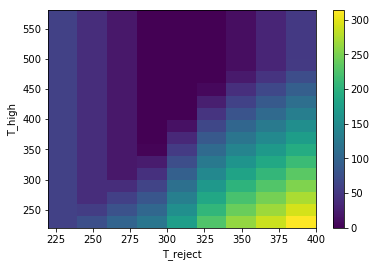

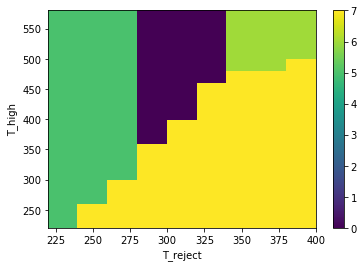

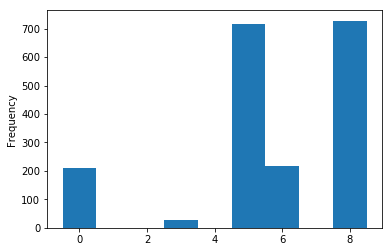

In [34]:
plt.figure()
#plt.contourf(T_med_range, T_high_range, violations.T, cmap='spring')
plt.pcolormesh(T_med_range, T_high_range, -v.values.reshape(shape)[3,:,:].T) #, cmap='spring')
plt.xlabel("T_reject")
plt.ylabel("T_high")
plt.colorbar()

plt.figure()
#plt.imshow(worst[:,::-1].T)
plt.pcolormesh(T_med_range,T_high_range,worst.values.reshape(shape)[3,:,:].T,vmin=0,vmax=7)
#plt.contourf(T_med_range, T_high_range, worst.T, cmap='Pastel1', vmin=0, vmax=255 )
plt.xlabel("T_reject")
plt.ylabel("T_high")
plt.colorbar()

plt.figure()
worst.plot.hist(bins=numpy.arange(-0.5,AquaChillerSpec1.n_cons))

plt.show()

In [62]:
import pyvtk
grid = pyvtk.RectilinearGrid(T_high_range,T_med_range,T_low_range)
vtk = pyvtk.VtkData(grid)
vtk.point_data.append(pyvtk.Scalars(-v.values,
                                    name='Feasibility cost'))
vtk.point_data.append(pyvtk.Scalars(worst.values.astype('float'),
                                    name='Cause of failure'))
vtk.tofile('feasibility_ammonia_data.vtk')

### Problem cases

In [311]:
# Problem cases ... should work but don't. Wow.
for T_med in [396.666667]:
    print(amm.props2(T=T_med,x=0.9998,Qu=0.000001))
for T_med in [396.666666,396.666668,396.666667]:
    print(amm.props2(T=T_med,x=0.9998,Qu=0.00000))

State(T=396.666667, P=102.11911867081996, x=0.9998, h=655.3371030500907, s=1.9179410016989382, u=632.079587356763, v=0.0022774442432729365, Qu=1e-06)
State(T=396.666666, P=130.71246947558606, x=0.9998, h=652.5895375913475, s=1.8947393278504907, u=622.8633116836049, v=0.0022748701284714405, Qu=0.0)
State(T=396.666668, P=102.05594348386495, x=0.9998, h=655.2895597768476, s=1.918085931480245, u=632.0484545407089, v=0.0022772893899859624, Qu=0.0)


KeyError: "DLL returned b'Saturation properties cannot be determined for the given input variables'"

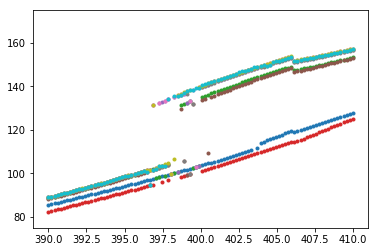

In [56]:
#T=numpy.linspace(350,500,100)
T=numpy.linspace(390,410,100)
P0=T.copy(); P0.fill(nan)
P1=P0.copy()
for x in [0.98, 0.998, 0.9998, 0.99998, 0.999998]:
    for i,t in enumerate(T):
        try:
            P0[i]=amm.props2(T=t,x=x,Qu=0,out='P')
            P1[i]=amm.props2(T=t,x=x,Qu=1,out='P')
        except:
            pass
    plt.plot(T,P0,'.')
    plt.plot(T,P1,'.')
plt.ylim(75,175)
plt.show()

## Appendix

### Visualize relations between a few variables of state

In [1]:
import CoolProp
import CoolProp.CoolProp as CP
import numpy
from numpy import array, inf, nan
import matplotlib.pyplot as plt
T0, x0, Qu0 = 350., 0.8, 1.0
P0 = CP.PropsSI('P','T',T0,'Q',Qu0,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))

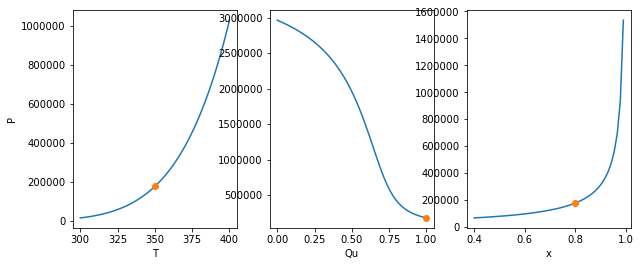

In [2]:
T = numpy.linspace(300,400)
Qu = numpy.linspace(0,1)
x = numpy.linspace(0.4,0.99)

plt.close('all')
fig = plt.figure(figsize=[10,4])

#CP.PropsSI('P','T',350, 'Q',1,"REFPROP::ammonia[0.1]&water[0.9]")
P_vs_T = CP.PropsSI('P','T',T,'Q',Qu0,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))
fig.add_subplot(131)
plt.plot(T, P_vs_T)
plt.plot(T0, P0, 'o')
plt.xlabel('T')
plt.ylabel('P')

P_vs_Qu = CP.PropsSI('P','T',T0,'Q',Qu,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))
fig.add_subplot(132)
plt.plot(Qu, P_vs_Qu)
plt.plot(Qu0, P0, 'o')
plt.xlabel('Qu')

P_vs_x = array([CP.PropsSI('P','T',T0,'Q',Qu0,"REFPROP::ammonia[{}]&water[{}]".format(xi,1.-xi))
                for xi in x])
fig.add_subplot(133)
plt.plot(x, P_vs_x)
plt.plot(x0, P0, 'o')
plt.xlabel('x')

plt.show()

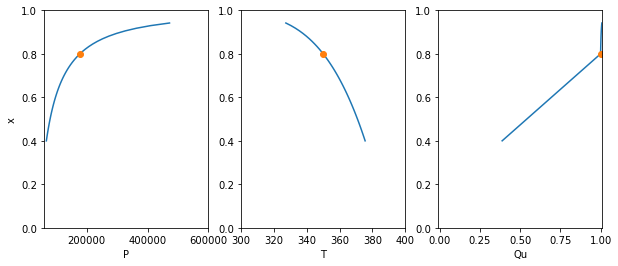

In [15]:
qt5 = False
if qt5:
    %matplotlib qt5
else:
    %matplotlib inline
plt.close('all')
fig = plt.figure(figsize=[10,4])
ax1=fig.add_subplot(131)
ax1.set_ylim(0,1)
ax1.set_xlim(6e4, 6e5)
ax1.set_ylabel('x')
ax1.set_xlabel('P')

ax2=fig.add_subplot(132)
ax2.set_ylim(0,1)
ax2.set_xlim(3e2, 4e2)
ax2.set_xlabel('T')

ax3=fig.add_subplot(133)
ax3.set_ylim(0,1)
ax3.set_xlim(-1e-2, 1+1e-2)
ax3.set_xlabel('Qu')

if qt5:
    ax1.plot(P0, x0, 'o')
    ax2.plot(T0, x0, 'o')
    ax3.plot(Qu0, x0, 'o')

pointopts = dict(color='grey', alpha=0.5, markersize=5.)

CPRP = CoolProp.AbstractState("REFPROP","ammonia&water")
PTQ = numpy.empty([3,len(x)])
PTQ.fill(nan)
try:
    for i,xi in enumerate(x):
        #print("Case", i, flush=True)
        if i > 45:
            continue
        CPRP.set_mole_fractions([xi,1-xi])
        try:
            CPRP.update(CoolProp.QT_INPUTS,Qu0,T0)
            pi = CPRP.p()
        except ValueError:
            pi = nan
            
        try:
            CPRP.update(CoolProp.PQ_INPUTS,P0,Qu0)
            ti = CPRP.T()
        except ValueError:
            ti = nan
            
        try:
            CPRP.update(CoolProp.PT_INPUTS,P0,T0)
            qi = CPRP.Q()
        except ValueError:
            qi = nan
        if qt5:
            ax1.plot(pi, xi, 'o', **pointopts)
            ax2.plot(ti, xi, 'o', **pointopts)
            ax3.plot(qi, xi, 'o', **pointopts)
            fig.canvas.draw()
            fig.canvas.flush_events()
        else:
            PTQ[:,i] = pi, ti, qi
except:
    pass

if not qt5:
    ax1.plot(PTQ[0,:], x)
    ax2.plot(PTQ[1,:], x)
    ax3.plot(PTQ[2,:], x)
    ax1.plot(P0, x0, 'o')
    ax2.plot(T0, x0, 'o')
    ax3.plot(Qu0, x0, 'o')

    plt.show()

In [57]:
# Absorber "Good case": P_evap is greater than the equilibrium P0; quality is lower than 1.
P_evap = P0 * 1.1
Qu_imagined = CP.PropsSI('Q','T',T0,'P',P_evap,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))
Qu_imagined

0.9675526740934721

In [58]:
# Absorber "Bad case": P_evap is less than the equilibrium P0; quality is greater than 1.
P_evap = P0 * 0.9
Qu_imagined = CP.PropsSI('Q','T',T0,'P',P_evap,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))
Qu_imagined

1.0005894260535513

### Evaporator vapor quality effect on operating pressure and maximum solution rich mass fraction

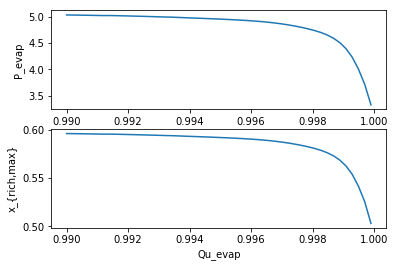

In [215]:
# What is the effect of vapor quality at evaporator outlet?
Qu_evap = numpy.linspace(0.99,0.9999)
T,P_evap,x,h,s,u,v,Qu=amm.props2v(T=278,x=0.9998,Qu=Qu_evap)
T,P,x_abs,h,s,u,v,Qu=amm.props2v(T=300,P=P,Qu=0)

fig=plt.figure()
ax1=fig.add_subplot(211)
ax1.set_ylabel('P_evap')
ax1.plot(Qu_evap,P_evap)

ax2=fig.add_subplot(212)
ax2.set_ylabel('x_{rich,max}')
ax2.set_xlabel('Qu_evap')
ax2.plot(Qu_evap,x_abs)
plt.show()

In [31]:
%%html
<textarea id="TOC-markdown" style="font-family:monospace;width:80%;height:20em;">TOC will be here</textarea>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').filter(":has(a)").map(function(){
        return "  ".repeat($(this).prop("tagName")[1]) 
          + "- <a href='" + encodeURI($(this).children().attr("href")) + "'>"
          + $(this).text() + "</a>";}).get().join("\n")
    );
</script>